In [1]:
import pandas as pd
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader
import wandb
from omegaconf import OmegaConf
import os

from Botfip.datagen.opt_datagen import Op_dataset
from Botfip.datagen.data_utils import custom_collate
from Botfip.datagen.data_utils import Multiscale_MeshDataset
from Botfip.operation.operation_tree import OperationRandomTree

In [2]:
hyperparameters_yaml_path = 'configs/model_hyper.yaml'
config = OmegaConf.load(hyperparameters_yaml_path)


1.88*Abs((-x_0 + x_1 - 0.858)**(1/3))**0.5 - 0.273


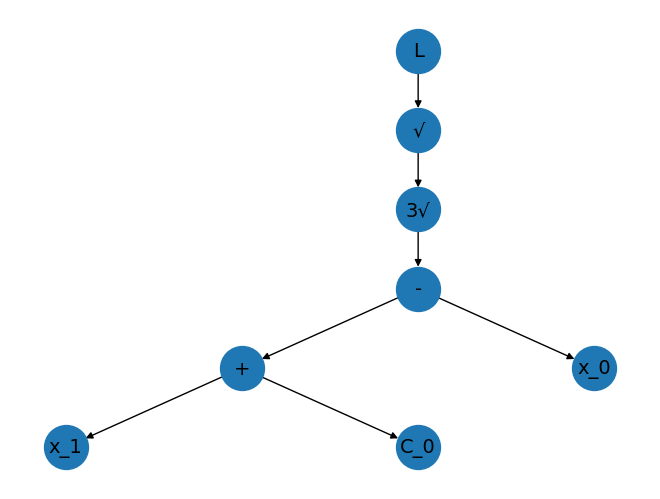

In [9]:
opt = OperationRandomTree.from_config_yaml(8,hyperparameters_yaml_path)
opt.random_assign_operations()
print(opt.to_formula_str(type='full'))
opt.draw_tree()

In [10]:
opseq,op_constant = opt.tree_serialized_encode_seq(if_ignore_root = True)
print(opseq,op_constant)

[16, 0, 17, 0, 2, 0, 1, 18, 0, 19, 10, 0, 0, 0, 0] [-0.85762299  1.88441416 -0.27345497]


In [11]:
opt_reco = OperationRandomTree.load_tree_ots(opseq,hyperparameters_yaml_path,constant_array=op_constant)
print(opt.to_formula_str(type='full'))

1.88*Abs((-x_0 + x_1 - 0.858)**(1/3))**0.5 - 0.273


In [29]:
op_dataset = Op_dataset(hyperparameters_yaml_path,if_load=True)
op_dataloader = DataLoader(op_dataset, batch_size=1, collate_fn=custom_collate,shuffle=True,drop_last=True,num_workers=0)

In [5]:
op_dataset[0].keys()

dict_keys(['funcimg', 'original_funcimg', 'funcimg_max', 'funcimg_min', 'opseq', 'const_array', 'set_node_num', 'img_index', 'skeleton_index'])

In [15]:
samples = next(iter(op_dataloader))
print(samples.keys())
opseq,op_constant = samples['opseq']

dict_keys(['funcimg', 'original_funcimg', 'funcimg_max', 'funcimg_min', 'opseq', 'set_node_num', 'img_index', 'skeleton_index'])


In [7]:
from Botfip.model import op_tokenizer
tokenizer = op_tokenizer.from_config(config)
a = tokenizer.tokenize(opseq,op_constant)


In [8]:
from Botfip.model import BlipPretrain
device = 'cuda'
model = BlipPretrain.from_config(config,train_parameters_key='blip_pretrain_config').to(device)

In [9]:
samples['epoch'] = 0
samples['iters'] = 0
samples['num_iters_per_epoch'] = 10
samples['funcimg'] = samples['funcimg'].to(device)
output=model(samples,
             cal_itc_itm_loss=True,
                cal_lm_loss=True,)

In [10]:
output_seq_list,pred_const_array = model.opseq_generate(samples['funcimg'].to(device),if_compute_constant=True)

In [11]:
from Botfip.trainer import Botfip_trainer
botfip_trainer =Botfip_trainer.build_from_yaml(hyperparameters_yaml_path,if_ddp=False)

val_dataset =  Op_dataset(hyperparameters_yaml_path,if_load=True,dataset_key='op_dataset_config',load_dataset_path='/home/cth/nfs_store/dataset/new_formal_dataset_4')
val_dataloader = DataLoader(val_dataset, batch_size=20, collate_fn=custom_collate,shuffle=True,drop_last=True,num_workers=0)

op_dataset len: 551400


In [30]:
samples = next(iter(op_dataloader))
funcimg = samples['funcimg'].to(device)

opseq_target, op_constants_target = samples['opseq']
opseq_pred, op_constants_pred  = botfip_trainer.model.opseq_generate(funcimg,device='cuda')

mesh_dataset = Multiscale_MeshDataset(sys_range = (-1,1),
                                      multiscale_channels = 3,
                                      max_var_types = config.operation_tree_config.max_var_types,
                                      img_shape = 64)
meshgrid = mesh_dataset.mesh
target_mesh_grid = meshgrid[1:2].to('cuda')


In [31]:
op_constants_target

[[-0.3, 1.7]]

In [32]:
const_array,pred_funcimg,loss = botfip_trainer.model.const_update(hyperparameters_yaml_path,opseq_target,funcimg,target_mesh_grid,optimizer='lbfgs')

epoch 0: loss 1.8805980682373047
epoch 1: loss 0.1285092532634735
